# Segmentación de cultivo y maleza en agricultura de precisión aplicando U-Net

Pontificia Universidad Católica del Perú

Escuela de Posgrado PUCP, Maestría en Informática, Ciencias de la Computacion

Curso: 
- Técnicas avanzadas de data mining y sistemas inteligentes

Alumnos:
- 20173589 Alarcon Flores, Jorge Brian
- 20173685 Chicchón Apaza, Miguel Angel
- 20173789 Alvarez Mouravskaia, Kevin
- 20173810 Pacheco Condori, Jesús Edwar

## Librerías

In [257]:
import numpy as np
import cv2 #https://opencv-python-tutroals.readthedocs.io/en/latest/index.html
import glob #https://docs.python.org/2/library/glob.html
from skimage.transform import rescale, resize #https://scikit-image.org/
from tqdm import tqdm_notebook as tqdm
import logging
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [349]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [246]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## Lectura de datos

In [219]:
def make_label(a):
    """
    Método que etiqueta los labels según colores
    Fuente: elaboración propia
    """    
    if a[1] == 255:
        a[0] = 1
    elif a[2] == 255:
        a[1] = 1
    else:
        a[2] = 1
    return a

In [221]:
class DatasetProvider():
    """
    Clase que lee el dataset
    Fuente: elaboración propia
    """
    def __init__(self, scale=1.0/6.0):
        self.scale = scale
        self.x, self.y = self.__run__()
        
    def __run__(self):
        labels = self.__read_images__('annotation') 
        images = self.__read_images__('image') 
        x = self.__create_x__(images)
        y = self.__create_y_annotations__(labels)
        return x, y
        
    def __create_x__(self, images):
        logging.info('Creando imágenes')
        scale = self.scale
        height, width, channels = images[0].shape
        x = np.zeros((len(images), int(height * scale), int(width * scale), channels))
        for i, image in tqdm(enumerate(images)):
            image_rescaled = rescale(image, scale, anti_aliasing=True, multichannel=True, mode='reflect')
            x[i,:,:,:] = image_rescaled
        return x
    
    def __create_y_annotations__(self, annotations, shape=3):
        logging.info('Creando labels')
        scale = self.scale
        height, width, channels = annotations[0].shape
        labels = np.zeros((height, width, shape))
        y = np.zeros((len(annotations), int(height * scale), int(width * scale), shape))
        for i, image in tqdm(enumerate(annotations)):
            np_image = np.array(image)
            np_image = np.apply_along_axis(make_label, -1, np_image)
            image_rescaled = rescale(np_image, scale, anti_aliasing=True, multichannel=True, mode='reflect')
            y[i,:,:,:] = image_rescaled
        return y
        
    def __read_images__(self, prefix):
        logging.info('Leyendo imágenes {}'.format(prefix))
        images = []
        path = '../dataset/cwfid/' + prefix + 's'
        files = glob.glob(path + "/*.png")
        for i, img_name in enumerate(files):
            path_img = img_name.replace('\\','/')
            img = cv2.imread(path_img)
            images.append(img)
        return images

In [222]:
def execute_dataset_provider():
    dataset_provider = DatasetProvider()
    X = dataset_provider.x
    y = dataset_provider.y
    return X, y

In [223]:
X, y = execute_dataset_provider()

2018-11-05 02:18:42,251 Leyendo imágenes annotation
2018-11-05 02:18:43,022 Leyendo imágenes image
2018-11-05 02:18:44,899 Creando imágenes


2018-11-05 02:18:53,663 Creando labels


In [321]:
X.shape, y.shape

((60, 161, 216, 3), (60, 161, 216, 3))

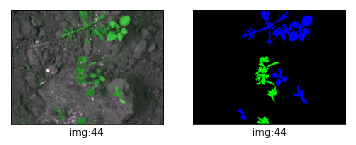

In [256]:
np.random.seed(0)
sample_idx = np.random.choice(len(X))  

plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.xlabel('img:{}'.format(sample_idx))
plt.imshow(X[sample_idx,:,:,:])

plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.xlabel('img:{}'.format(sample_idx))
plt.imshow(y[sample_idx,:,:,:])

## Pre entrenamiento (Aumentación)

In [331]:
class DatasetAugmentation():
    
    def __init__(self, X, y):
        self.X, self.y = self.__run__(X, y)
        
    def __run__(self, X, y):
        logging.info('Realizando aumentación')
        X_augmentated = X
        y_augmentated = y
        for i, x_image in tqdm(enumerate(X)):
            fliplr_x_image = np.fliplr(x_image)
            flipup_x_image = np.flipud(x_image)
            fliplr_y_image = np.fliplr(y[i])
            flipup_y_image = np.flipud(y[i])
            X_augmentated = np.append(X_augmentated, [fliplr_x_image], axis=0)
            X_augmentated = np.append(X_augmentated, [flipup_x_image], axis=0)
            y_augmentated = np.append(y_augmentated, [fliplr_y_image], axis=0)
            y_augmentated = np.append(y_augmentated, [flipup_y_image], axis=0)
        return X_augmentated, y_augmentated

In [332]:
def execute_dataset_pretrain(X, y):
    dataset = DatasetAugmentation(X, y)
    X_augmentated =  dataset.X
    y_augmentated = dataset.y
    return X_augmentated, y_augmentated

In [333]:
X_augmentated, y_augmentated = execute_dataset_pretrain(X, y)

2018-11-05 03:03:31,093 Realizando aumentación


In [334]:
X_augmentated.shape, y_augmentated.shape

((180, 161, 216, 3), (180, 161, 216, 3))

## Train validation split

In [335]:
X_train, X_val, y_train, y_val = train_test_split(X_augmentated, y_augmentated, test_size=0.2, random_state=42)

In [336]:
X_train.shape, X_val.shape

((144, 161, 216, 3), (36, 161, 216, 3))

## Pre entrenamiento (normalización)

In [359]:
X_mean = X_train.mean()
X_std = X_train.std()
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std

## Métricas

In [338]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## Modelo

In [374]:
class ModelCreator():
    
    #Fuente: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
    def unet(self, height, width, channels):
        
        inputs = Input((height, width, channels))
        s = Lambda(lambda x: x / 255) (inputs)

        c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
        c1 = Dropout(0.1) (c1)
        c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
        p1 = MaxPooling2D((2, 2)) (c1)

        c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
        c2 = Dropout(0.1) (c2)
        c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
        c3 = Dropout(0.2) (c3)
        c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
        p3 = MaxPooling2D((2, 2)) (c3)

        c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
        c4 = Dropout(0.2) (c4)
        c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

        c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
        c5 = Dropout(0.3) (c5)
        c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
        
#         up_conv5 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv5)
#         ch, cw = get_crop_shape(conv4, up_conv5)
#         crop_conv4 = Cropping2D(cropping=(ch,cw), data_format="channels_last")(conv4)
#         up6   = concatenate([up_conv5, crop_conv4], axis=concat_axis)`

        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
#         u6 = UpSampling2D(size=(2, 2), data_format="channels_last")(c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
        c6 = Dropout(0.2) (c6)
        c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

        u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
        c7 = Dropout(0.2) (c7)
        c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

        u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
        c8 = Dropout(0.1) (c8)
        c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
        c9 = Dropout(0.1) (c9)
        c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

        outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
        
        return model    

In [372]:
def execute_model():
    print()
    model = ModelCreator()
    model_unet = model.unet(X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [375]:
execute_model()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 20, 26, 128), (None, 20, 27, 128)]